In [44]:
!pip install autogluon
!pip install dask

In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OrdinalEncoder,OneHotEncoder 
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [46]:
data = pd.read_csv("train.csv")
author= pd.read_csv("authorData.csv")

In [47]:
author

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image
0,0,1655713481254,en,100,0,999,d2e03f4b7a57a6828392a80b6d8667c3,25,0,NaN,False,True,True,False
1,0,1655743160254,en,100,-5,5,5622c71671e9b0ab9052fd574876b46d,9,0,NaN,False,False,False,False
2,3486,1655395750254,en,100,-5,454592,9b72b401edaf6aec6603856a3a6fb050,45,0,NaN,False,False,False,False
3,7,1654621088254,ar,100,5,19348,dc3d6148b435c40a4e75e7d6b5bd22c9,10,0,NaN,False,False,False,False
4,0,1655754531254,en,45,-5,973,0e47c55a7918dd9130da37a80e46a2e0,14,0,NaN,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629872,479,1655694387254,en,100,0,129015,b0727df747f870315a651ce8864023a1,23,0,NaN,False,False,False,False
629873,161,1653691877254,en,4,0,27467,be2260a0684d01ec8567f73ef9650277,11,0,NaN,False,False,True,False
629874,0,1655766485254,en,94,5,401,012777f856a2162bb318ae7c15e2d280,19,0,NaN,False,True,False,False
629875,0,1655618304254,en,35,0,305008,5fd84f30702e9d0ab236e44a8328ae30,18,0,NaN,False,True,False,False


In [48]:
def author_stats_transform(df):
    grouped = df.groupby('author')

    # Compute desired statistics
    author_stats = grouped.agg({
        'engagement': ['mean', 'var'],  # Engagement mean and variance
        'timestamp': ['mean', 'var'],   # Timestamp mean and variance
        'language': lambda x: x.nunique(),  # Number of languages used
        'feature1': ['mean', 'var'],    # Feature1 mean and variance
        'word_count': ['mean', 'var'],  # Word count mean and variance
        'shared_url_count': 'sum',      # Sum for ratio calculation
        'is_reply': 'sum',
        'is_retweet': 'sum',
        'contains_video': 'sum',
        'contains_image': 'sum',
    })

    # Add ratios
    for feature in ['shared_url_count', 'is_reply', 'is_retweet', 'contains_video', 'contains_image']:
        author_stats[(feature, 'ratio')] = author_stats[(feature, 'sum')] / grouped.size().values

    # Flatten MultiIndex columns
    author_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in author_stats.columns]

    # Reset index
    author_stats = author_stats.reset_index()

    return author_stats

# Create a FunctionTransformer
author_transformer = FunctionTransformer(author_stats_transform)

In [49]:
author_pipeline = Pipeline(steps=[
    ('author_stats', author_transformer)
])

# Apply the pipeline to the data
transformed_author_data = author_pipeline.fit_transform(author)

In [50]:
transformed_author_data.columns

Index(['author', 'engagement_mean', 'engagement_var', 'timestamp_mean',
       'timestamp_var', 'language_<lambda>', 'feature1_mean', 'feature1_var',
       'word_count_mean', 'word_count_var', 'shared_url_count_sum',
       'is_reply_sum', 'is_retweet_sum', 'contains_video_sum',
       'contains_image_sum', 'shared_url_count_ratio', 'is_reply_ratio',
       'is_retweet_ratio', 'contains_video_ratio', 'contains_image_ratio'],
      dtype='object')

In [51]:
print(transformed_author_data)

                                author  engagement_mean  engagement_var  \
0     000937aef33e1c1651b43616a537e950      4540.638298    3.365825e+07   
1     000aa833711cac113db32b27a0308d31       185.320755    1.687403e+06   
2     001b70fc3722cb19b0df0b60acaa7ba2         7.520548    1.279947e+03   
3     001e518db4b054910bad6b31e5c82dbe         0.000000    0.000000e+00   
4     0036e542c6bef4571dd825d349778f5f         0.000000    0.000000e+00   
...                                ...              ...             ...   
8121  ffd1c89d7019cb1d2573cdd6e4e51f2c        87.470000    5.143577e+04   
8122  ffe13128b714104d425bb7b93ea7eb95       137.252525    7.416211e+03   
8123  ffe62359ac71d76df3f0c2b49bed8792      1986.777778    1.323326e+06   
8124  ffeaa6f16c5b334ae71fa07ed0db4e93      1207.131313    6.387039e+05   
8125  fffceff6a9a0355bcb0ae8d2b2b6d167       104.000000    7.094698e+04   

      timestamp_mean  timestamp_var  language_<lambda>  feature1_mean  \
0       1.654450e+12   4.7

In [52]:
# Merge the transformed data back into the original dataset
data_with_author_stats = data.merge(
    transformed_author_data,
    on='author',  # Merge based on the 'author' column
    how='left'    # Use 'left' to preserve the original rows
)

# Drop the original 'author' column if no longer needed
data_with_author_stats = data_with_author_stats.drop(columns=['author','shared_url_count_sum',
       'is_reply_sum', 'is_retweet_sum', 'contains_video_sum',
       'contains_image_sum','is_retweet'])


In [53]:
print(data_with_author_stats)

      engagement      timestamp language  feature1  feature2  followers  \
0             15  1655784230254       en        73         0        696   
1          91007  1655599613254       en       100         5      17526   
2              3  1655788872254       en         0        -5        239   
3             11  1655788810254       en       100        -5      21531   
4            235  1655789250254       en       100         5     101278   
...          ...            ...      ...       ...       ...        ...   
4149          40  1655757328254       en       100         0       8781   
4150           0  1655789504254       en       100         0       1347   
4151           0  1655789228254       en        50         0       2299   
4152       31988  1655772495254       en       100         0     143736   
4153           0  1655789289254       en       100         0       1550   

      word_count  shared_url_count shared_url_domain  is_reply  ...  \
0             18            

In [54]:
# Target col
y_col = 'engagement'

X = data_with_author_stats.drop(labels=y_col, axis=1)
Y = data_with_author_stats[y_col] 
# Meta cols and Text Embedding cols
meta_columns = ['timestamp', 'language', 'feature1', 'feature2','followers', 
                'word_count', 'shared_url_count','shared_url_domain','is_reply', 'contains_video', 'contains_image','engagement_mean', 'engagement_var', 'timestamp_mean',
       'timestamp_var', 'language_<lambda>', 'feature1_mean', 'feature1_var', 'word_count_mean',
       'word_count_var', 'shared_url_count_ratio', 'is_reply_ratio',
       'is_retweet_ratio', 'contains_video_ratio', 'contains_image_ratio']
emb_columns = data_with_author_stats.columns[12:1036]
print(emb_columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V1015', 'V1016', 'V1017', 'V1018', 'V1019', 'V1020', 'V1021', 'V1022',
       'V1023', 'V1024'],
      dtype='object', length=1024)


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [56]:
# Divide dataset to meta and emb datasets
train_meta_X = X_train[meta_columns]
train_emb_X = X_train[emb_columns]

test_meta_X = X_test[meta_columns]
test_emb_X = X_test[emb_columns]

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Custom transformer for time-based features
class TimeFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, timestamp_column):
        self.timestamp_column = timestamp_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.timestamp_column] = pd.to_datetime(X[self.timestamp_column], unit='ms')
        min_sinc_mid = X[self.timestamp_column].dt.hour * 60+X[self.timestamp_column].dt.minute
        norm_time=(2* np.pi * min_sinc_mid)/1440
        X["sin_daytime"]=np.sin(norm_time).round(3)
        X["cos_daytime"]=np.sin(norm_time).round(3)
        X['day_of_week'] = X[self.timestamp_column].dt.dayofweek  # Day of the week
        X['day_of_month'] = X[self.timestamp_column].dt.day  # Day of the month
        return X[['sin_daytime','cos_daytime', 'day_of_week', 'day_of_month']]


In [58]:
# 1. Log transform followers
log_transformer = FunctionTransformer(lambda x: np.log1p(x))
time_extractor = TimeFeatureExtractor(timestamp_column='timestamp')
time_feature_columns = ['sin_daytime','cos_daytime','day_of_week', 'day_of_month']

# 2.Ordinal Encoding for feature2 and shared_url_count
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

unique_feature2_values = train_meta_X['feature2'].unique()
onehot_feature2_columns = [f'feature2_{val}' for val in unique_feature2_values]

mean_imputer = SimpleImputer(strategy='mean')  # Fills missing values with the mean
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)  # Fills missing values with 0

# 3. Standardization for numerical columns
standard_scaler1 = StandardScaler()
standard_scaler2 = StandardScaler()
standard_scaler3 = StandardScaler()
minmax_scaler = MinMaxScaler()

# Custom function to encode boolean features
def convert_booleans(X):
    boolean_cols = ['is_reply', 'contains_video', 'contains_image']
    for col in boolean_cols:
        if col in X.columns:
            X[col] = X[col].astype(int)  # Convert boolean to integer
    return X

boolean_encoder = FunctionTransformer(convert_booleans)

# Updated ColumnTransformer
mean_columns = [
    'engagement_mean', 'engagement_var', 'timestamp_mean', 'timestamp_var', 
    'feature1_mean', 'feature1_var', 'word_count_mean', 'word_count_var'
]
zero_columns = [
    'language_<lambda>', 'shared_url_count_ratio', 'is_reply_ratio', 
    'is_retweet_ratio', 'contains_video_ratio', 'contains_image_ratio'
]

# Define meta_columns to include only the specified columns
meta_columns = [
    'timestamp', 'language', 'feature1', 'feature2', 'followers', 'word_count', 
    'shared_url_count', 'shared_url_domain', 'is_reply', 'contains_video', 
    'contains_image'
] + mean_columns + zero_columns

# Updated ColumnTransformer with all transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', ['language', 'shared_url_domain']),  # Drop unnecessary columns
        ('scale_followers', Pipeline([('impute', mean_imputer),  ('scale', standard_scaler1) ]), ['followers']),
        ('scale_timestamp', Pipeline([('impute', mean_imputer),  ('scale', standard_scaler1) ]), ['timestamp']),

        ('word_count', Pipeline([('impute', mean_imputer), ('scale', standard_scaler2)]), ['word_count']),  # Log-transform word_count
        ('time_features', Pipeline([  # Extract and standardize time features
            ('extract_time', time_extractor),
            ('scale_time', standard_scaler3)
        ]), ['timestamp']),
        ('hot', onehot_encoder, ['feature2']),  # One-hot encode feature2
        ('min_max', Pipeline([('impute', mean_imputer), ('scale', minmax_scaler)]), ['shared_url_count']),  # Min-Max scaling for shared_url_count
        ('scale_feature1', Pipeline([('impute', mean_imputer), ('scale', standard_scaler2)]), ['feature1']),  # Standardize feature1
        ('encode_booleans', boolean_encoder, ['is_reply', 'contains_video', 'contains_image']) ,  # Convert and impute booleans
        ('mean_impute', Pipeline([('impute', mean_imputer)]), mean_columns),  # Fill mean_columns with mean
        ('zero_impute', Pipeline([('impute', zero_imputer)]), zero_columns)  # Fill zero_columns with 0
    ],
    remainder='passthrough'  # Keep all other columns as they are
)



pass_through_columns = [col for col in meta_columns if col not in (
    ['language', 'shared_url_domain', 'followers', 'word_count', 'timestamp', 
     'feature2', 'shared_url_count', 'feature1'] + mean_columns + zero_columns
)]

# Define new column names
processed_columns = (
    ['scaled_followers','scaled_timestamp', 'scaled_word_count'] +  # Log-transformed features
    time_feature_columns +  # Extracted time features
    onehot_feature2_columns +  # One-hot encoded columns for feature2
    ['norm_shared_url_count', 'std_feature1'] +  # Scaled features
    mean_columns +  # Columns filled with the mean
    zero_columns +  # Columns filled with 0
    pass_through_columns  # Columns passed through
)
print(processed_columns)
# Apply the pipeline to the dataframe
meta_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


# Apply the pipeline to the dataframe
train_processed_meta_X = meta_pipeline.fit_transform(train_meta_X)
test_processed_meta_X = meta_pipeline.transform(test_meta_X)

# Convert the output to a DataFrame for readability*
train_processed_meta_df = pd.DataFrame(train_processed_meta_X, columns=processed_columns)
test_processed_meta_df = pd.DataFrame(test_processed_meta_X, columns=processed_columns)

['scaled_followers', 'scaled_timestamp', 'scaled_word_count', 'sin_daytime', 'cos_daytime', 'day_of_week', 'day_of_month', 'feature2_5', 'feature2_0', 'feature2_-5', 'norm_shared_url_count', 'std_feature1', 'engagement_mean', 'engagement_var', 'timestamp_mean', 'timestamp_var', 'feature1_mean', 'feature1_var', 'word_count_mean', 'word_count_var', 'language_<lambda>', 'shared_url_count_ratio', 'is_reply_ratio', 'is_retweet_ratio', 'contains_video_ratio', 'contains_image_ratio', 'is_reply', 'contains_video', 'contains_image']


In [59]:
# Pipeline for embeddings preprocessing
embedding_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Step 1: Standardize embeddings
    #('pca', PCA(n_components=0.95)),  # Step 2: PCA to retain 95% variance
    ('pca', PCA(n_components=100)),  # Step 2: PCA to retain 100 components
    #('feature_selection', SelectFromModel(RandomForestRegressor(), threshold='median'))  # Step 3: Feature selection
])

# Fit-transform embeddings pipeline
train_processed_emb_X = embedding_pipeline.fit_transform(train_emb_X) #, y_train)
test_processed_emb_X = embedding_pipeline.transform(test_emb_X) #, y_train)

# Combine embeddings with preprocessed features
train_final_data = np.hstack([train_processed_meta_df.values, train_processed_emb_X])
test_final_data = np.hstack([test_processed_meta_df.values,test_processed_emb_X])

# Convert final data into a DataFrame for easier handling
preprocessed_feature_names = train_processed_meta_df.columns.tolist()
embedding_feature_names = [f"embedding_{i}" for i in range(train_processed_emb_X.shape[1])]
final_columns = preprocessed_feature_names + embedding_feature_names 

train_final_data_df = pd.DataFrame(train_final_data, columns=final_columns)
test_final_data_df = pd.DataFrame(test_final_data, columns=final_columns)

processed_X=pd.concat([train_final_data_df, test_final_data_df], axis=0, ignore_index=True)

In [60]:
!pip install lightgbm
!pip install catboost

# Model #

In [61]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import PoissonRegressor, GammaRegressor, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

models_and_distributions ={
    "AdaBoost" : {
    "model": AdaBoostRegressor(random_state=42),
    "params": {
        "n_estimators": randint(50, 300),
        "learning_rate": uniform(0.01, 1),
        "loss": ["linear", "square", "exponential"],  # AdaBoost loss functions
    }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": randint(50, 300),
            "max_depth": randint(5, 20),
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5)
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, verbosity=0),
        "params": {
            "n_estimators": randint(50, 300),
            "learning_rate": uniform(0.01, 0.2),
            "max_depth": randint(3, 10),
            "reg_alpha": uniform(0, 1),
            "reg_lambda": uniform(1, 10)
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42, verbosity=0),
        "params": {
            "n_estimators": randint(50, 300),
            "learning_rate": uniform(0.01, 0.2),
            "max_depth": randint(5, 20),
            "num_leaves": randint(15, 63),
            "min_child_samples": randint(10, 50)
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(random_state=42, verbose=0),
        "params": {
            "iterations": randint(50, 300),
            "learning_rate": uniform(0.01, 0.2),
            "depth": randint(4, 10),
            "l2_leaf_reg": uniform(1, 5)
        }
    },
    "Poisson Regression": {
        "model": PoissonRegressor(),
        "params": {
            "alpha": uniform(0.1, 10),
            "max_iter": randint(100, 200)
        }
    },
    "Lasso": {
        "model": Lasso(),
        "params": {
            "alpha": uniform(0.01, 1)
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "alpha": uniform(0.01, 1),
            "l1_ratio": uniform(0.1, 0.9)
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": randint(1, 20),
            "weights": ["uniform", "distance"],
            "p": [1, 2]  # Manhattan distance (p=1) or Euclidean distance (p=2)
        }
    }
}


# Function to perform hyperparameter tuning and evaluate a model
def tune_and_evaluate_model(name, model, params, X_train, X_test, y_train, y_test):
    random_search = RandomizedSearchCV(
        model,
        params,
        n_iter=10,  # Number of parameter combinations to test
        cv=3,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        verbose=3,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return {
        "Best Params": random_search.best_params_,
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MSLE": mean_squared_log_error(y_test, np.maximum(y_pred, 0)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R^2": r2_score(y_test, y_pred)
    }

In [62]:
# Evaluate all models, 
np.random.seed(42)
np.random.seed(42)

results = {}
for name, data in tqdm(models_and_distributions.items()):
    print(f"Tuning and evaluating {name}...")
    results[name] = tune_and_evaluate_model(name, data["model"], data["params"], X_train, X_test, y_train, y_test)

  0%|          | 0/9 [00:00<?, ?it/s]

Tuning and evaluating AdaBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


  0%|          | 0/9 [00:05<?, ?it/s]


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 133, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1064, in check_array
    _assert_all_finite(
  File "c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 108, in _assert_all_finite
    raise ValueError("Input contains NaN")
ValueError: Input contains NaN


In [148]:
# Convert results to a DataFrame for presentation
results_df3 = pd.DataFrame(results).T
results_df3.sort_values(by="RMSE", ascending=True, inplace=True)

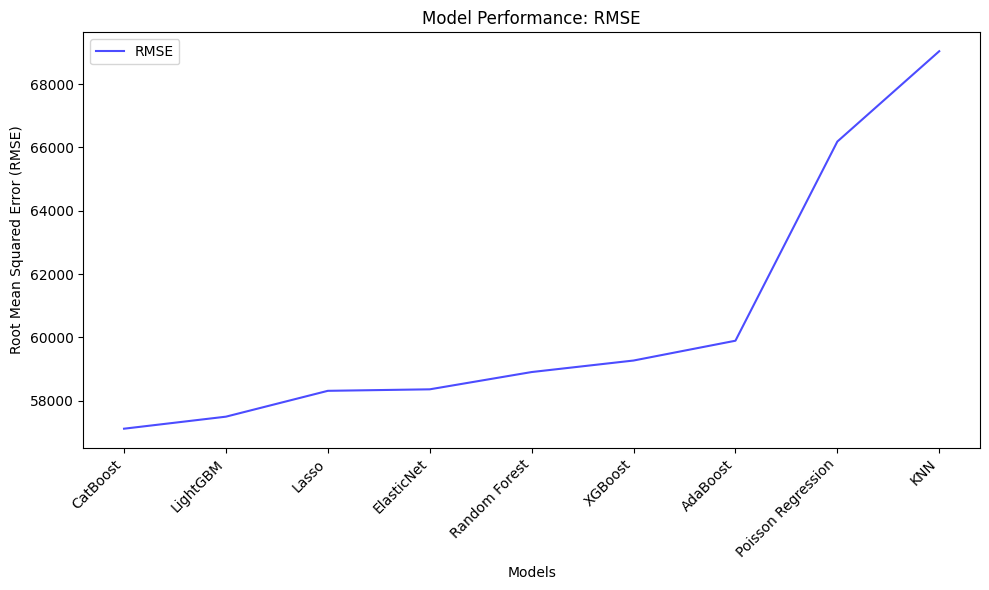

In [149]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(results_df3.index, results_df3["RMSE"], alpha=0.7, color='blue', label="RMSE")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Models")
plt.title("Model Performance: RMSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend()
plt.show()

In [150]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [151]:
# Extract the list of (name, best_params) tuples
best_params_dict = {name: details["Best Params"] for name, details in results.items()}

# Display the resulting list
best_params_dict

{'AdaBoost': {'learning_rate': 0.03306242504141576,
  'loss': 'exponential',
  'n_estimators': 108},
 'Random Forest': {'max_depth': 15,
  'min_samples_leaf': 4,
  'min_samples_split': 6,
  'n_estimators': 70},
 'XGBoost': {'learning_rate': 0.19771054180315006,
  'max_depth': 4,
  'n_estimators': 241,
  'reg_alpha': 0.9922115592912175,
  'reg_lambda': 7.1748150962771655},
 'LightGBM': {'learning_rate': 0.04410482473745831,
  'max_depth': 11,
  'min_child_samples': 27,
  'n_estimators': 181,
  'num_leaves': 39},
 'CatBoost': {'depth': 7,
  'iterations': 237,
  'l2_leaf_reg': 2.8318092164684585,
  'learning_rate': 0.10121399684340719},
 'Poisson Regression': {'alpha': 3.845401188473625, 'max_iter': 192},
 'Lasso': {'alpha': 0.9607143064099162},
 'ElasticNet': {'alpha': 0.8424426408004217, 'l1_ratio': 0.29110519961044856},
 'KNN': {'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}}

In [153]:
# Step 2: Define base models
from sklearn.ensemble import RandomForestRegressor

base_models = [
    ("LightGBM", LGBMRegressor(random_state=42, verbosity=-1, **best_params_dict["LightGBM"])),
    ("XGBoost", XGBRegressor(random_state=42, verbosity=0, **best_params_dict["XGBoost"])),
    ("CatBoost", CatBoostRegressor(random_state=42, verbose=0, **best_params_dict["CatBoost"])),
    ("AdaBoost", AdaBoostRegressor(random_state=42, **best_params_dict["AdaBoost"])),    
    #("Poisson Regression", PoissonRegressor(**best_params_dict["Poisson Regression"])),
    ("Lasso", Lasso(**best_params_dict["Lasso"])),
    ("ElasticNet", ElasticNet(**best_params_dict["ElasticNet"])),
    ("Random Forest", RandomForestRegressor(random_state=42, **best_params_dict["Random Forest"]))
]

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
# Step 3: Cross-validation to generate out-of-fold predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features = np.zeros((X_train.shape[0], len(base_models)))  # Placeholder for meta-model features

for idx, (name, model) in enumerate(base_models):
    oof_predictions = np.zeros(X_train.shape[0])  # Out-of-fold predictions
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # Train the base model
        model.fit(X_tr, y_tr)
        
        # Predict on validation fold
        oof_predictions[val_idx] = model.predict(X_val)
    
    # Store out-of-fold predictions for this model
    meta_features[:, idx] = oof_predictions
    
# Kinda important here: Scale the meta-features ()
scaler = StandardScaler()
meta_features_scaled = scaler.fit_transform(meta_features)  # Scale training meta-features

c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.959e+12, tolerance: 1.064e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+12, tolerance: 8.503e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

# Meta_Model #

In [154]:
# Step 5: Generate test set predictions
# First, generate predictions from base models on the test set
test_meta_features = np.column_stack([
    model.predict(X_test) for _, model in base_models
])

# Scale the test meta-features
test_meta_features_scaled = scaler.transform(test_meta_features)

In [155]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint, uniform

# Define meta models and their distributions
meta_models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {},  # No hyperparameters to tune
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            "alpha": uniform(0.1, 10),
        },
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "alpha": uniform(0.01, 1),
            "l1_ratio": uniform(0.1, 0.9),
        },
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": randint(50, 300),
            "max_depth": randint(5, 20),
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5),
        },
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, verbosity=0),
        "params": {
            "n_estimators": randint(50, 300),
            "learning_rate": uniform(0.01, 0.2),
            "max_depth": randint(3, 10),
            "reg_alpha": uniform(0, 1),
            "reg_lambda": uniform(1, 10),
        },
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42, verbosity=0),
        "params": {
            "n_estimators": randint(50, 300),
            "learning_rate": uniform(0.01, 0.2),
            "max_depth": randint(5, 20),
            "num_leaves": randint(15, 63),
            "min_child_samples": randint(10, 50),
        },
    },
    "CatBoost": {
        "model": CatBoostRegressor(random_state=42, verbose=0),
        "params": {
            "iterations": randint(50, 300),
            "learning_rate": uniform(0.01, 0.2),
            "depth": randint(4, 10),
            "l2_leaf_reg": uniform(1, 5),
        },
    },
    "Poisson Regression": {
        "model": PoissonRegressor(),
        "params": {
            "alpha": uniform(0.1, 10),
            "max_iter": randint(100, 200),
        },
    },
    "Lasso": {
        "model": Lasso(),
        "params": {
            "alpha": uniform(0.01, 1),
        },
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": randint(1, 20),
            "weights": ["uniform", "distance"],
            "p": [1, 2],  # Manhattan distance (p=1) or Euclidean distance (p=2)
        },
    },
    "MLP": {
        "model": MLPRegressor(max_iter=1000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "alpha": uniform(0.0001, 0.01),
            "learning_rate": ["constant", "adaptive"],
        },
    },
}


# Function to perform hyperparameter tuning and evaluate a model
def tune_and_evaluate_model(name, model, params, X_train, X_test, y_train, y_test):
    random_search = RandomizedSearchCV(
        model,
        params,
        n_iter=10,  # Number of parameter combinations to test
        cv=3,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        verbose=3,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return {
        "Best Params": random_search.best_params_,
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MSLE": mean_squared_log_error(y_test, np.maximum(y_pred, 0)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R^2": r2_score(y_test, y_pred)
    }

In [156]:
# Evaluate all models, 
results1 = {}
for name, data in tqdm(meta_models.items()):
    print(f"Tuning and evaluating {name}...")
    results1[name] = tune_and_evaluate_model(name, data["model"], data["params"], meta_features_scaled, test_meta_features_scaled, y_train, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 18%|█▊        | 2/11 [00:00<00:00, 19.78it/s]c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\

Tuning and evaluating LinearRegression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning and evaluating Ridge...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning and evaluating ElasticNet...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning and evaluating Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 36%|███▋      | 4/11 [00:07<00:15,  2.26s/it]

Tuning and evaluating XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 45%|████▌     | 5/11 [00:09<00:12,  2.01s/it]

Tuning and evaluating LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 55%|█████▍    | 6/11 [00:10<00:09,  1.91s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 64%|██████▎   | 7/11 [00:17<00:13,  3.34s/it]c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 82%|████████▏ | 9/11 [00:17<00:03,  1.84s/it]

Tuning and evaluating Poisson Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning and evaluating Lasso...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning and evaluating KNN...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 91%|█████████ | 10/11 [00:17<00:01,  1.41s/it]

Tuning and evaluating MLP...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 11/11 [00:41<00:00,  3.79s/it]


In [157]:
# Convert results to a DataFrame for presentation
results_df2 = pd.DataFrame(results1).T
results_df2.sort_values(by="RMSE", ascending=True, inplace=True)

In [158]:
results_df2

,Best Params,RMSE,MSLE,MAE,R^2
MLP,"{'alpha': 0.0031424224295953773, 'hidden_layer...",57178.769307,11.004003,18354.818071,0.253586
ElasticNet,"{'alpha': 0.4419450186421158, 'l1_ratio': 0.36...",57510.52992,16.854329,20664.233559,0.244899
Ridge,{'alpha': 9.60714306409916},57860.014565,16.903852,21337.117344,0.235694
Lasso,{'alpha': 0.9607143064099162},57884.498552,17.080259,21393.205819,0.235047
LinearRegression,{},57884.920036,17.081095,21395.226935,0.235036
CatBoost,"{'depth': 4, 'iterations': 253, 'l2_leaf_reg':...",58655.059344,20.169441,20599.097043,0.214545
Random Forest,"{'max_depth': 8, 'min_samples_leaf': 4, 'min_s...",59749.671338,11.903492,20083.129693,0.184956
Poisson Regression,"{'alpha': 0.30584494295802445, 'max_iter': 101}",59916.705161,24.974022,22002.304327,0.180392
KNN,"{'n_neighbors': 15, 'p': 1, 'weights': 'distan...",61737.983538,12.50496,20185.95601,0.129808
XGBoost,"{'learning_rate': 0.0412037280884873, 'max_dep...",61916.286798,14.405135,20704.21723,0.124775


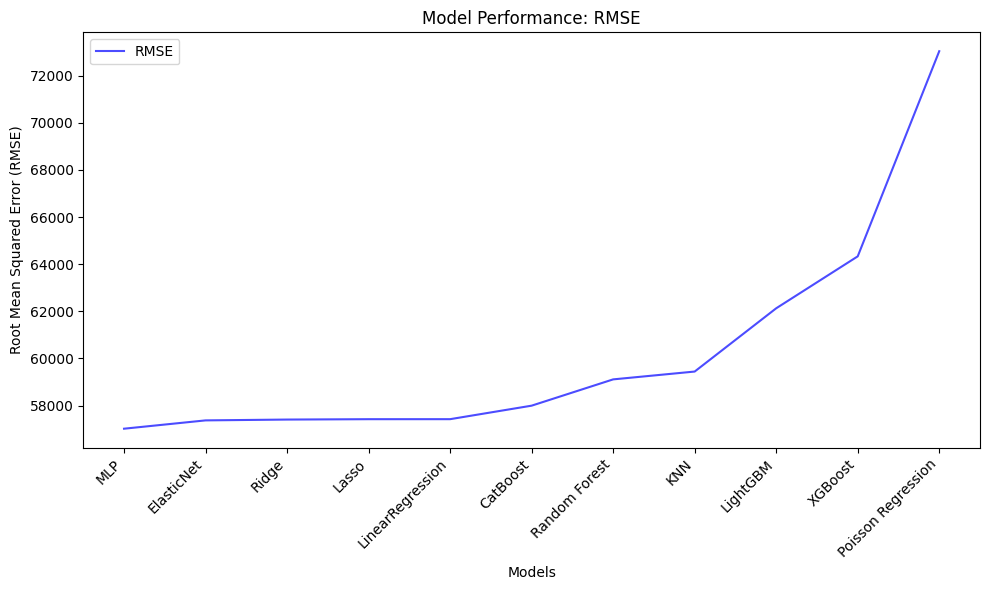

In [98]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(results_df2.index, results_df2["RMSE"], alpha=0.7, color='blue', label="RMSE")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Models")
plt.title("Model Performance: RMSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend()
plt.show()

In [159]:
# Extract the list of (name, best_params) tuples
best_params_dict1 = {name: details["Best Params"] for name, details in results1.items()}

# Display the resulting list
best_params_dict1

{'LinearRegression': {},
 'Ridge': {'alpha': 9.60714306409916},
 'ElasticNet': {'alpha': 0.4419450186421158, 'l1_ratio': 0.36210622617823773},
 'Random Forest': {'max_depth': 8,
  'min_samples_leaf': 4,
  'min_samples_split': 9,
  'n_estimators': 180},
 'XGBoost': {'learning_rate': 0.0412037280884873,
  'max_depth': 5,
  'n_estimators': 264,
  'reg_alpha': 0.05808361216819946,
  'reg_lambda': 9.661761457749352},
 'LightGBM': {'learning_rate': 0.04410482473745831,
  'max_depth': 11,
  'min_child_samples': 27,
  'n_estimators': 181,
  'num_leaves': 39},
 'CatBoost': {'depth': 4,
  'iterations': 253,
  'l2_leaf_reg': 4.0582658024414044,
  'learning_rate': 0.011413261043943482},
 'Poisson Regression': {'alpha': 0.30584494295802445, 'max_iter': 101},
 'Lasso': {'alpha': 0.9607143064099162},
 'KNN': {'n_neighbors': 15, 'p': 1, 'weights': 'distance'},
 'MLP': {'alpha': 0.0031424224295953773,
  'hidden_layer_sizes': (100,),
  'learning_rate': 'constant'}}

In [160]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Defining the best meta- Model

In [181]:
metamodels_name = results_df2['RMSE'].idxmin()
best_params=results_df2.loc[metamodels_name, 'Best Params']
print(metamodels_name)
best_model=meta_models[metamodels_name]['model']
best_model.set_params(**best_params)


MLP


MLPRegressor(alpha=0.0031424224295953773, max_iter=1000)

In [183]:
best_model.fit(meta_features_scaled,y_train)

c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.0031424224295953773, max_iter=1000)

In [185]:
final_predictions=best_model.predict(test_meta_features_scaled)

In [186]:
# Evaluate the model
rmse = mean_squared_error(y_test, final_predictions, squared=False)
msle = mean_squared_log_error(y_test, np.maximum(final_predictions, 0))
mae = mean_absolute_error(y_test, final_predictions)
r2 = r2_score(y_test, final_predictions)

print(f"Model Evaluation:")
print(f" - Mean Root Squared Error (MSLE): {rmse:.4f}")
print(f" - Mean Squared Log Error (MSLE): {msle:.4f}")
print(f" - Mean Absolute Error (MAE): {mae:.4f}")
print(f" - R^2 Score: {r2:.4f}")

Model Evaluation:
 - Mean Root Squared Error (MSLE): 57159.2747
 - Mean Squared Log Error (MSLE): 14.2100
 - Mean Absolute Error (MAE): 18489.8386
 - R^2 Score: 0.2541


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


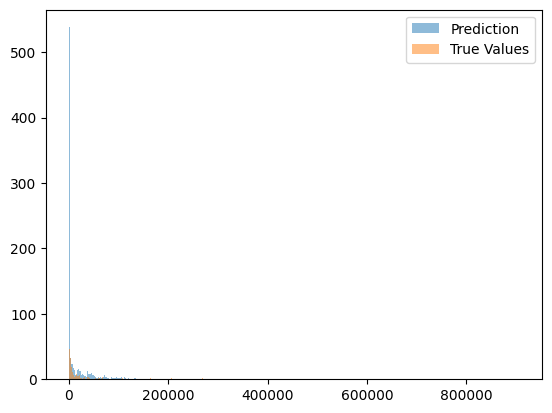

In [187]:
plt.hist(final_predictions, bins='auto', alpha=0.5, label='Prediction')
plt.hist(y_test, bins='auto', alpha=0.5, label='True Values')
plt.legend(loc='upper right')
plt.show()

In [188]:
final_predictions_non_zero = final_predictions
final_predictions_non_zero[final_predictions <= 0] = 0

In [189]:
# Evaluate the model
rmse = mean_squared_error(y_test, final_predictions, squared=False)
msle = mean_squared_log_error(y_test, np.maximum(final_predictions, 0))
mae = mean_absolute_error(y_test, final_predictions)
r2 = r2_score(y_test, final_predictions)

print(f"Model Evaluation:")
print(f" - Mean Root Squared Error (MSLE): {rmse:.4f}")
print(f" - Mean Squared Log Error (MSLE): {msle:.4f}")
print(f" - Mean Absolute Error (MAE): {mae:.4f}")
print(f" - R^2 Score: {r2:.4f}")

Model Evaluation:
 - Mean Root Squared Error (MSLE): 57159.2747
 - Mean Squared Log Error (MSLE): 14.2100
 - Mean Absolute Error (MAE): 18489.8386
 - R^2 Score: 0.2541


c:\Users\JLASSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


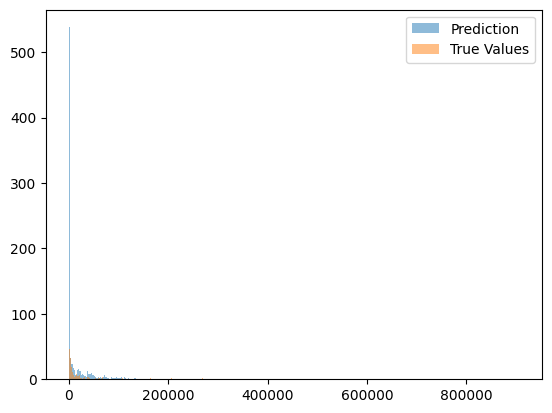

In [190]:
plt.hist(final_predictions, bins='auto', alpha=0.5, label='Prediction')
plt.hist(y_test, bins='auto', alpha=0.5, label='True Values')
plt.legend(loc='upper right')
plt.show()

# Explainibiliy #

In [ ]:
! pip install shap

Processing model: LightGBM
SHAP Summary for LightGBM


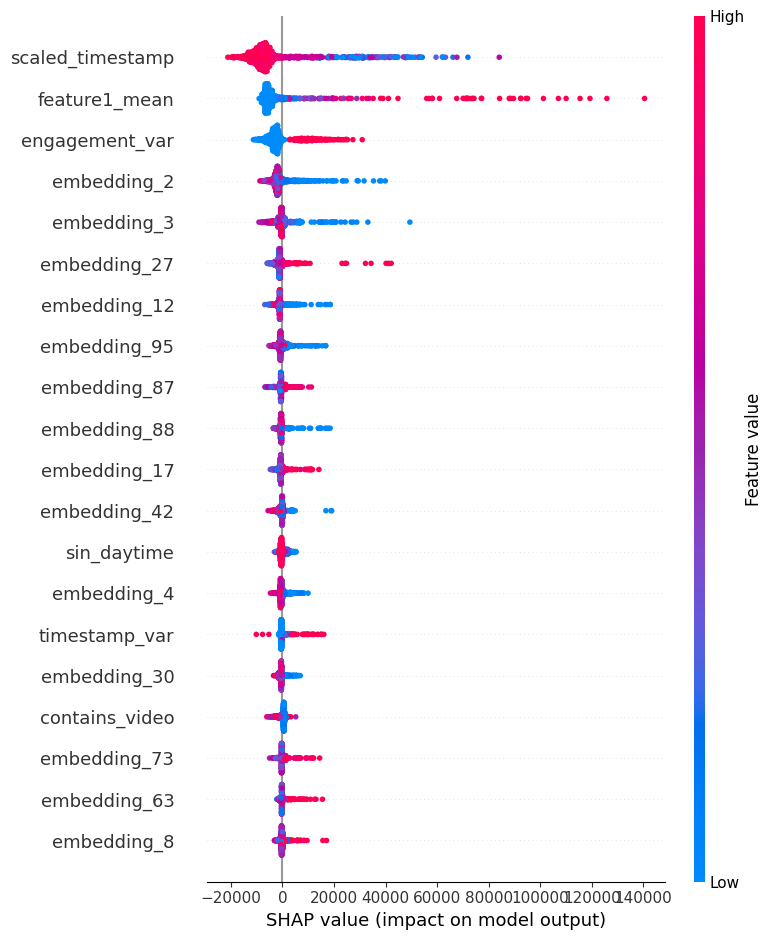

Processing model: XGBoost
SHAP Summary for XGBoost


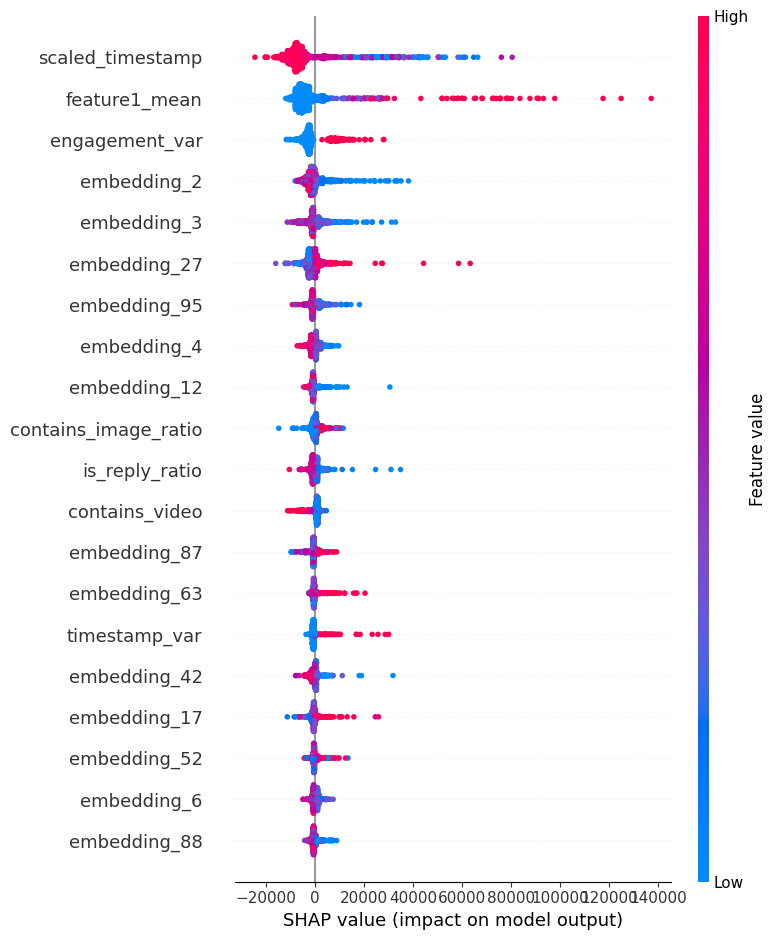

Processing model: CatBoost


KeyboardInterrupt: 

In [179]:
import pandas as pd
import shap
X_train_pd = pd.DataFrame(X_train, columns=final_columns)  # Replace with actual names
X_test_pd = pd.DataFrame(X_test, columns=X_train_pd.columns)  # Ensure alignment

for name, model in base_models:
    print(f"Processing model: {name}")
    
    # Check the model type and select the appropriate SHAP explainer
    if name in ["LightGBM", "XGBoost", "Random Forest", "CatBoost"]:
        explainer = shap.Explainer(model, X_train_pd)
    elif name in ["Lasso", "ElasticNet"]:
        explainer = shap.LinearExplainer(model, X_train_pd)
    else:
        print(f"Model {name} not supported for SHAP")
        continue
    
    # Compute SHAP values
    shap_values = explainer(X_test_pd, check_additivity=False)
    
    # Print SHAP summary plot with feature names
    print(f"SHAP Summary for {name}")
    shap.summary_plot(shap_values, X_test_pd, feature_names=final_columns)


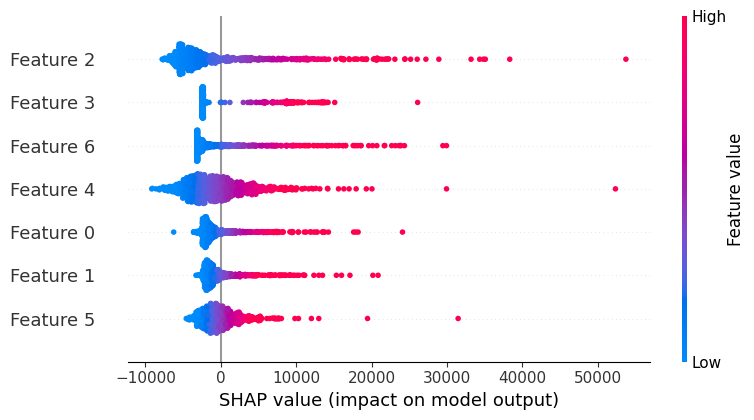

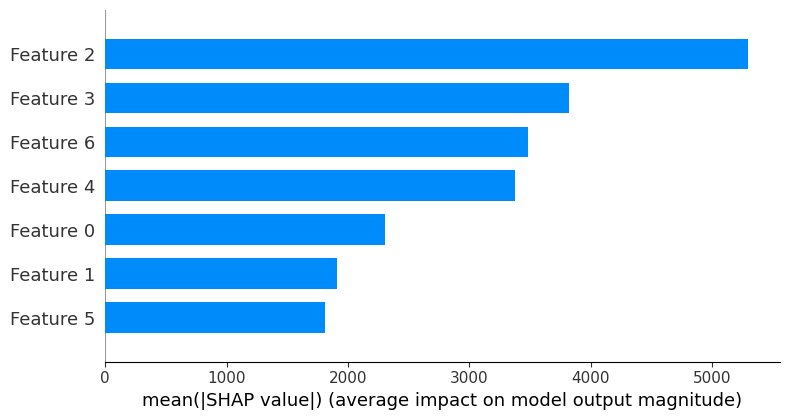

In [191]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Ensure test_meta_features_scaled is a DataFrame
feature_names = meta_features_scaled.columns if hasattr(meta_features_scaled, 'columns') else [f"Feature {i}" for i in range(meta_features_scaled.shape[1])]
test_meta_features_scaled = pd.DataFrame(test_meta_features_scaled, columns=feature_names)

# Create a SHAP explainer
explainer = shap.Explainer(meta_model, meta_features_scaled)

# Compute SHAP values (returns an Explanation object)
shap_values = explainer(test_meta_features_scaled)

# Visualize SHAP Summary Plot
shap.summary_plot(shap_values, test_meta_features_scaled)

# Visualize Feature Importance Plot
shap.summary_plot(shap_values, test_meta_features_scaled, plot_type="bar")

# Force Plot for a Single Prediction
shap.initjs()
shap.force_plot(
    shap_values[0].base_values,  # Base value for the prediction
    shap_values[0].values,      # SHAP values for the first instance
    shap_values[0].data,        # Feature values for the first instance
    feature_names=shap_values.feature_names  # Use feature names
)


# Submission #

In [192]:
# Read the dataset
submit_X = pd.read_csv("test.csv")


In [193]:
# Merge the transformed submit_X back into the original dataset
submit_X_with_author_stats = submit_X.merge(
    transformed_author_data,
    on='author',  # Merge based on the 'author' column
    how='left'    # Use 'left' to preserve the original rows
)

# Drop the original 'author' column if no longer needed
submit_X_with_author_stats = submit_X_with_author_stats.drop(columns=['author','shared_url_count_sum',
       'is_reply_sum', 'is_retweet_sum', 'contains_video_sum',
       'contains_image_sum','is_retweet'])

meta_columns = ['timestamp', 'language', 'feature1', 'feature2','followers', 
                'word_count', 'shared_url_count','shared_url_domain','is_reply', 'contains_video', 'contains_image','engagement_mean', 'engagement_var', 'timestamp_mean',
       'timestamp_var', 'language_<lambda>', 'feature1_mean', 'feature1_var', 'word_count_mean',
       'word_count_var', 'shared_url_count_ratio', 'is_reply_ratio',
       'is_retweet_ratio', 'contains_video_ratio', 'contains_image_ratio']
emb_columns = submit_X_with_author_stats.columns[12:1036]


In [194]:
submit_meta_X = submit_X_with_author_stats[meta_columns]
submit_emb_X = submit_X_with_author_stats[emb_columns]

In [195]:
# Apply the pipeline to the dataframe
submit_processed_meta_X = meta_pipeline.transform(submit_meta_X)

# Convert the output to a DataFrame for readability*
submit_processed_meta_df = pd.DataFrame(submit_processed_meta_X, columns=processed_columns)


# Fit-transform embeddings pipeline
submit_processed_emb_X = embedding_pipeline.transform(submit_emb_X) 

# Combine embeddings with preprocessed features
submit_final_data = np.hstack([submit_processed_meta_df.values, submit_processed_emb_X])

# Convert final data into a DataFrame for easier handling
preprocessed_feature_names = submit_processed_meta_df.columns.tolist()
embedding_feature_names = [f"embedding_{i}" for i in range(submit_processed_emb_X.shape[1])]
final_columns = preprocessed_feature_names + embedding_feature_names

submit_final_data_df = pd.DataFrame(submit_final_data, columns=final_columns)

In [196]:
X_submit= submit_final_data

In [197]:
submit_meta_features = np.column_stack([
    model.predict(X_submit) for _, model in base_models
])

# Scale the test meta-features
submit_meta_features_scaled = scaler.transform(submit_meta_features)

# Predict using the meta-model
y_submit = meta_model.predict(submit_meta_features_scaled )

In [198]:
y_submit_non_zero = y_submit
y_submit_non_zero[y_submit <= 0] = 0

In [199]:
# Load sample_submission.csv for reference
sample_submission = pd.read_csv('sampleSubmission.csv')

# Create a DataFrame for submission
submission = pd.DataFrame({
    sample_submission.columns[0]: sample_submission[sample_submission.columns[0]],  # Identifier column
    sample_submission.columns[1]: y_submit_non_zero  # Target column
})

In [200]:
submission

,Id,engagement
0,1,5960.918887
1,2,10867.195244
2,3,23121.114708
3,4,40366.001567
4,5,1153.169534
...,...,...
1866,2493,0.000000
1867,2495,0.000000
1868,2496,9406.395584
1869,2498,19794.861488


In [201]:
# Save the submission file
submission.to_csv('submission2.csv', index=False)

print("Submission file created: submission1.csv")

Submission file created: submission1.csv
